In [1]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
import boto3
import importlib.util
import ast
import numpy as np
import networkx as nx
from scipy.stats import poisson

from dotenv import load_dotenv

In [2]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

# Validate environment variables
missing_vars = []
if not working_directory:
    missing_vars.append("PROJECT_WORKING_DIR")
if not data_directory:
    missing_vars.append("PROJECT_DATA_DIR")
if not references_directory:
    missing_vars.append("PROJECT_REFERENCES_DIR")
if not results_directory:
    missing_vars.append("PROJECT_RESULTS_DIR")
if not utils_directory:
    missing_vars.append("PROJECT_UTILS_DIR")

if missing_vars:
    print(f"⚠️ Warning: The following environment variables are missing: {', '.join(missing_vars)}")
    print("This may cause errors in some notebook operations.")
    print("Please configure these variables in your .env file and restart the notebook.")

os.environ["WORKING_DIRECTORY"] = working_directory
os.environ["DATA_DIRECTORY"] = data_directory
os.environ["REFERENCES_DIRECTORY"] = references_directory
os.environ["RESULTS_DIRECTORY"] = results_directory
os.environ["UTILS_DIRECTORY"] = utils_directory

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env
Working Directory: /home/lakishadavid/computational_genetic_genealogy
Data Directory: /home/lakishadavid/computational_genetic_genealogy/data
References Directory: /home/lakishadavid/computational_genetic_genealogy/references
Results Directory: /home/lakishadavid/computational_genetic_genealogy/results
Utils Directory: /home/lakishadavid/computational_genetic_genealogy/utils
The current directory is /home/lakishadavid/computational_genetic_genealogy


## ERSA λ from Equation 8

$$(a(rd+c))/2^{d−1} \cdot p(t)$$

In [3]:
# Use the table from Kong et al., 2002 to get the total autosomal genetic length
# Enter the value using digits and decimals only (i.e., no commas)
# This value is in centiMorgans (cM)
genome_length = 3435.71
# In your futher developed code, you should calculate the input_value
# for the genome_length from your recombination map.

# Looking at the lambda equation from Equation 8 from the ERSA paper
num_anc = 2  # a: number of ancestors. Enter your choice of 1 or 2

num_rec = genome_length / 100 # r: approximate number of recombination events per meiosis
# Note: The genome_length unit of measurement is cM. One Morgan (M) is 100 cM.
# The definition of a Morgan is the space where at least one recombination event will occur.
# Therefore, we divide our cM value by 100 cM because, on average, 1 recombination event
# will occur every 100 cM or 1 M.

num_chr = 22  # c: number of autosomes in humans

min_seg_len = 3 # t: minimum detectable segment length in cM

d = 6  # d: meiotic distance between individuals in a pair. Enter value of choice.

## The probability of a segment being longer than the threshold

$$p(t)= e^{-dt/100}$$

Recall that the following

$$e^x$$

is coded as follows:

```
import numpy as np

np.exp(x)
```

In [4]:
prob_greater_than_t = np.exp(-d * min_seg_len / 100)
print(prob_greater_than_t)

0.835270211411272


## Lambda mean is the mean number of segments shared

$$λ = (a(rd+c))/2^{d−1} \cdot p(t)$$

## ⚠️ Performance Notice

This notebook contains several cells that perform intensive computational simulations:

- Cells 8-16: Mathematical distribution calculations and visualizations
- Cell 16: Simulates 1,000 IBD segments between relatives
- Cell 20: Simulates relationships with 500-1,000 iterations per calculation

These simulations generally complete within reasonable timeframes (a few seconds per cell), but performance may vary based on your system. Each simulation is independent, so you can run them one at a time if needed.

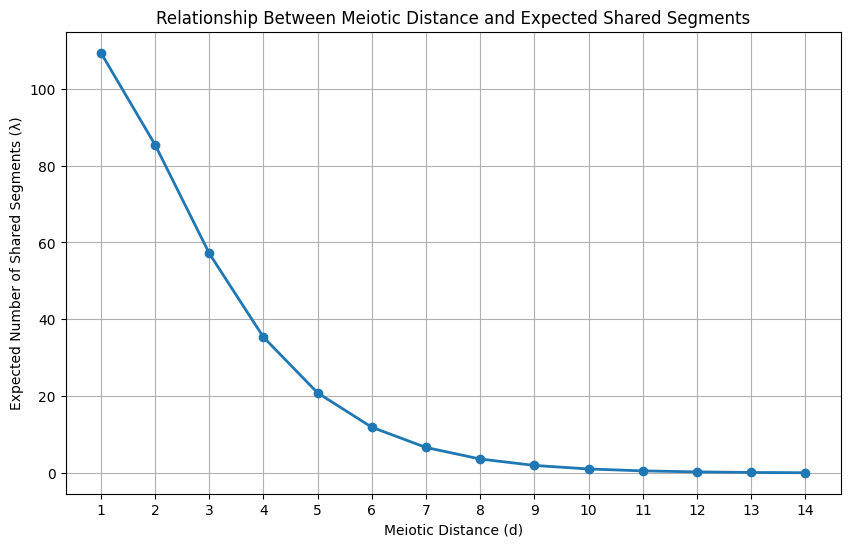

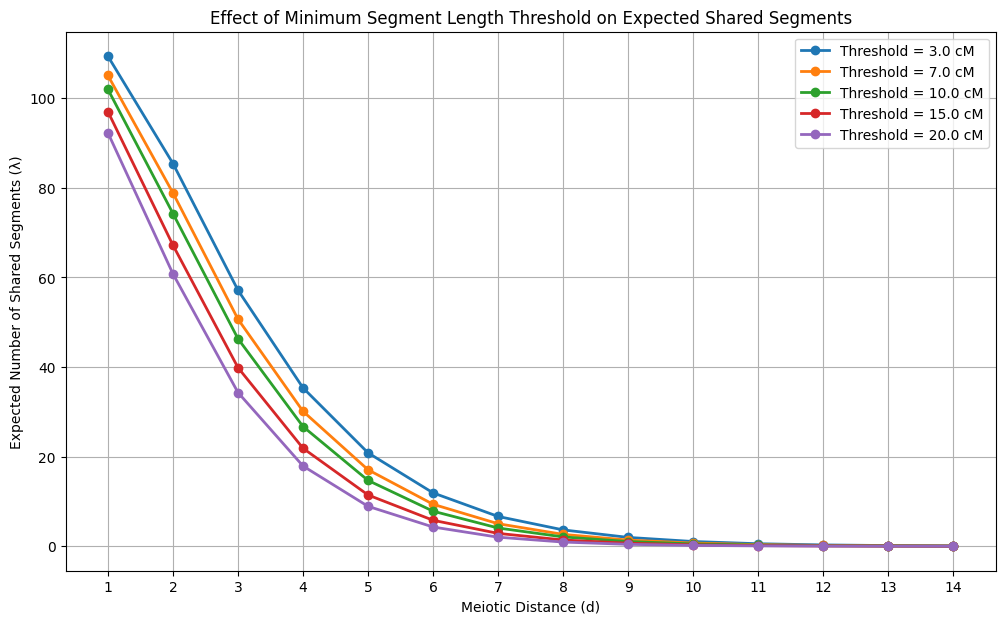

Lambda mean: 11.91004485836983


In [5]:
# Understanding genetic recombination and meiotic distance
# Let's explore how changing the meiotic distance affects the expected number of shared segments

meiotic_distances = range(1, 15)  # d values from 1 to 14
lambda_values = []

for d_val in meiotic_distances:
    prob_t = np.exp(-d_val * min_seg_len / 100)
    lambda_val = ((num_anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
    lambda_values.append(lambda_val)

plt.figure(figsize=(10, 6))
plt.plot(meiotic_distances, lambda_values, 'o-', linewidth=2)
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Number of Shared Segments (λ)')
plt.title('Relationship Between Meiotic Distance and Expected Shared Segments')
plt.grid(True)
plt.xticks(meiotic_distances)
plt.show()

# Let's also see how this relationship is affected by the minimum segment length threshold
thresholds = [3.0, 7.0, 10.0, 15.0, 20.0]  # Different minimum segment length thresholds
plt.figure(figsize=(12, 7))

for threshold in thresholds:
    lambda_values = []
    for d_val in meiotic_distances:
        prob_t = np.exp(-d_val * threshold / 100)
        lambda_val = ((num_anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
        lambda_values.append(lambda_val)
    plt.plot(meiotic_distances, lambda_values, 'o-', linewidth=2, label=f'Threshold = {threshold} cM')

plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Number of Shared Segments (λ)')
plt.title('Effect of Minimum Segment Length Threshold on Expected Shared Segments')
plt.grid(True)
plt.xticks(meiotic_distances)
plt.legend()
plt.show()

# Calculate lambda_mean for use in later cells
d_value = d  # Use the d value defined in cell 3
prob_t = np.exp(-d_value * min_seg_len / 100)
lambda_mean = ((num_anc * (num_rec * d_value + num_chr)) / (2 ** (d_value - 1))) * prob_t
print(f"Lambda mean: {lambda_mean}")

### Exploring the Poisson distribution for segment sharing

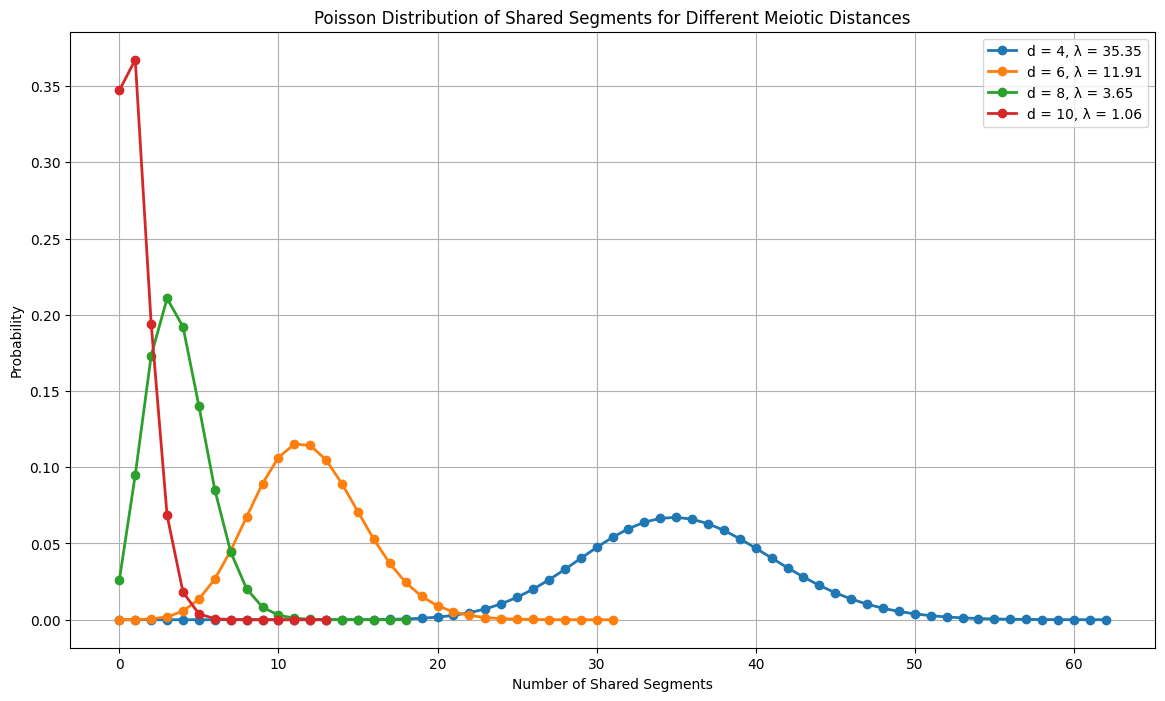

In [6]:
# Let's visualize how the Poisson distribution changes with different meiotic distances
d_values = [4, 6, 8, 10]
plt.figure(figsize=(14, 8))

for d_val in d_values:
    # Calculate lambda for this meiotic distance
    prob_t = np.exp(-d_val * min_seg_len / 100)
    lambda_val = ((num_anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
    
    # Create a range of segment count values for this lambda
    max_segments = int(lambda_val + 3 * np.sqrt(lambda_val)) + 10
    segment_counts = np.arange(0, max_segments)
    
    # Calculate Poisson PMF values
    pmf_values = poisson.pmf(segment_counts, lambda_val)
    
    # Plot the distribution
    plt.plot(segment_counts, pmf_values, 'o-', linewidth=2, 
             label=f'd = {d_val}, λ = {lambda_val:.2f}')

plt.xlabel('Number of Shared Segments')
plt.ylabel('Probability')
plt.title('Poisson Distribution of Shared Segments for Different Meiotic Distances')
plt.grid(True)
plt.legend()
plt.show()

### Exploring the relationship between ancestry and expected segments

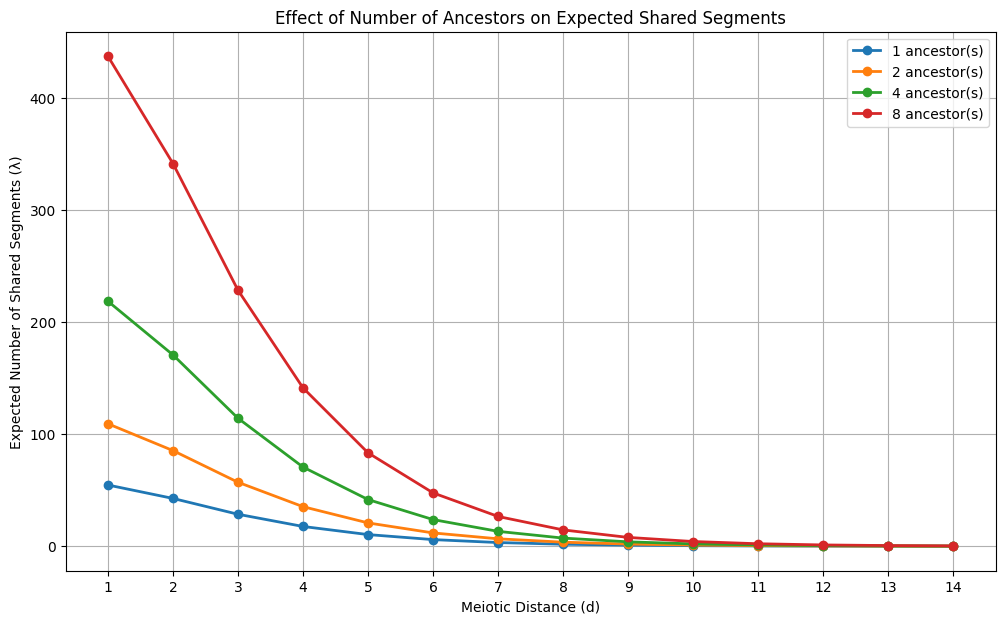

In [7]:
# Effect of number of ancestors on expected IBD segments
ancestor_values = [1, 2, 4, 8]  # Different possible values for num_anc
plt.figure(figsize=(12, 7))

for anc in ancestor_values:
    lambda_values = []
    for d_val in meiotic_distances:
        prob_t = np.exp(-d_val * min_seg_len / 100)
        lambda_val = ((anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
        lambda_values.append(lambda_val)
    plt.plot(meiotic_distances, lambda_values, 'o-', linewidth=2, label=f'{anc} ancestor(s)')

plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Number of Shared Segments (λ)')
plt.title('Effect of Number of Ancestors on Expected Shared Segments')
plt.grid(True)
plt.xticks(meiotic_distances)
plt.legend()
plt.show()

### Exploring the exponential distribution of segment lengths

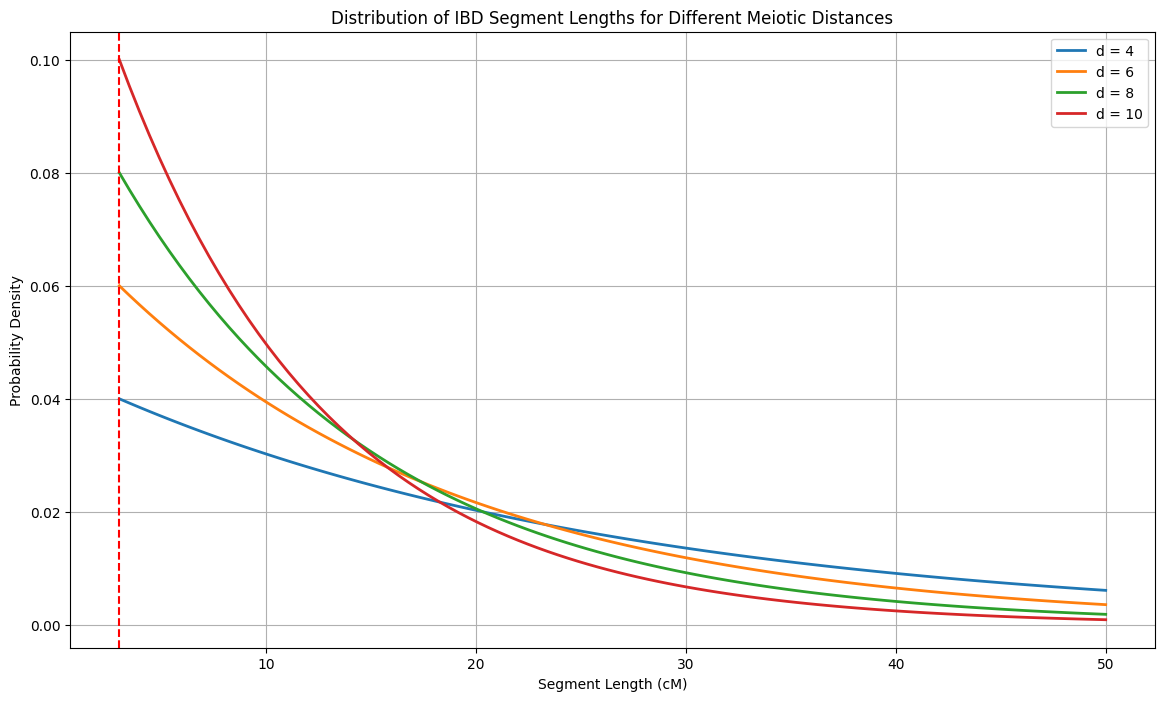

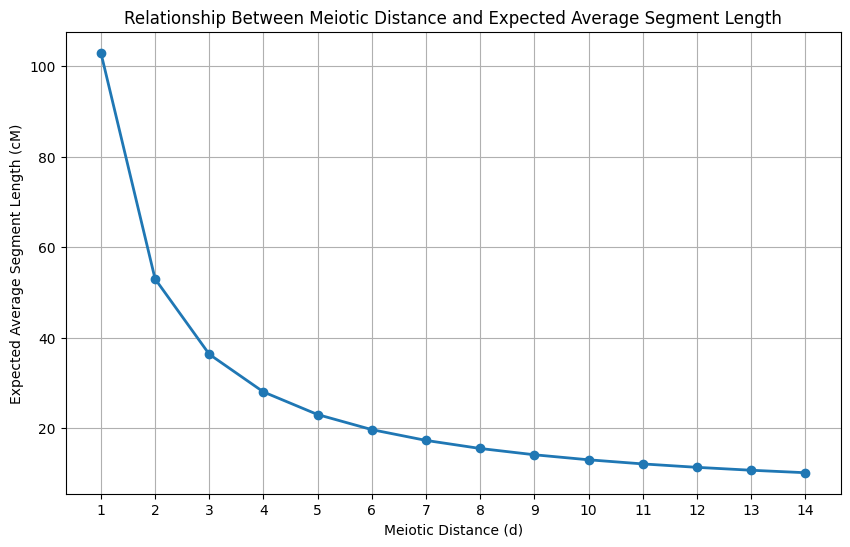

In [8]:
# Let's explore how meiotic distance affects the distribution of segment lengths
d_values = [4, 6, 8, 10]
plt.figure(figsize=(14, 8))

# Use fewer points for a cleaner visualization
length_range_plot = np.linspace(min_seg_len, 50, 100)

for d_val in d_values:
    # Calculate the segment length distribution
    length_distribution = np.exp(-d_val * (length_range_plot - min_seg_len) / 100) / (100 / d_val)
    
    # Plot the distribution
    plt.plot(length_range_plot, length_distribution, linewidth=2, 
             label=f'd = {d_val}')

plt.xlabel('Segment Length (cM)')
plt.ylabel('Probability Density')
plt.title('Distribution of IBD Segment Lengths for Different Meiotic Distances')
plt.grid(True)
plt.legend()
plt.axvline(x=min_seg_len, color='r', linestyle='--', label='Minimum threshold')
plt.show()

# Now let's calculate the expected average segment length for different meiotic distances
avg_lengths = []
for d_val in meiotic_distances:
    # The expected average length is 100/d + minimum threshold
    avg_length = 100/d_val + min_seg_len
    avg_lengths.append(avg_length)

plt.figure(figsize=(10, 6))
plt.plot(meiotic_distances, avg_lengths, 'o-', linewidth=2)
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Average Segment Length (cM)')
plt.title('Relationship Between Meiotic Distance and Expected Average Segment Length')
plt.grid(True)
plt.xticks(meiotic_distances)
plt.show()

### Simulating segment sharing between relatives

⚠️ **Note**: The following cell runs 1,000 simulations of IBD segment sharing. This typically completes in a few seconds, but may take longer on slower systems. The simulation generates realistic data that follows the statistical distributions discussed earlier.

In [9]:
def simulate_ibd_segments(d, min_length, num_ancestors, num_simulations=1000):
    """
    Simulate the number and total length of IBD segments shared between relatives.
    
    Parameters:
    d: meiotic distance
    min_length: minimum detectable segment length in cM
    num_ancestors: number of shared ancestors
    num_simulations: number of simulations to run
    
    Returns:
    segment_counts: array of number of segments in each simulation
    total_lengths: array of total length of segments in each simulation
    """
    # Validate parameters
    if d <= 0:
        raise ValueError("Meiotic distance (d) must be positive")
    if min_length < 0:
        raise ValueError("Minimum segment length must be non-negative")
    if num_ancestors <= 0:
        raise ValueError("Number of ancestors must be positive")
    if num_simulations <= 0:
        raise ValueError("Number of simulations must be positive")
        
    # Check if required global variables are defined
    required_vars = ['num_rec', 'num_chr']
    missing_vars = [var for var in required_vars if var not in globals()]
    if missing_vars:
        raise ValueError(f"Missing required global variables: {', '.join(missing_vars)}")
    
    # Calculate lambda (expected number of segments pre-filtering)
    lambda_pre = ((num_ancestors * (num_rec * d + num_chr)) / (2 ** (d - 1)))
    
    segment_counts = []
    total_lengths = []
    
    for _ in range(num_simulations):
        # Sample number of pre-filtered segments from Poisson
        num_segments_pre = np.random.poisson(lambda_pre)
        
        # For each segment, sample its length from exponential distribution
        segment_lengths = np.random.exponential(100/d, num_segments_pre)
        
        # Keep only segments above threshold
        kept_segments = segment_lengths[segment_lengths >= min_length]
        
        # Record results
        segment_counts.append(len(kept_segments))
        total_lengths.append(sum(kept_segments))
    
    return np.array(segment_counts), np.array(total_lengths)

### Comparing the Bonsai algorithm implementation with ERSA

                      Relationship  Meiotic Distance     ERSA λ   Bonsai λ  \
0                    First cousins                 4  17.675038  17.675038   
1                   Second cousins                 6   5.955022   5.955022   
2                    Third cousins                 8   1.824342   1.824342   
3                 Great-aunt/uncle                 4  17.675038  17.675038   
4  Half-first cousins once removed                 6  11.910045  11.910045   

   Difference  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  


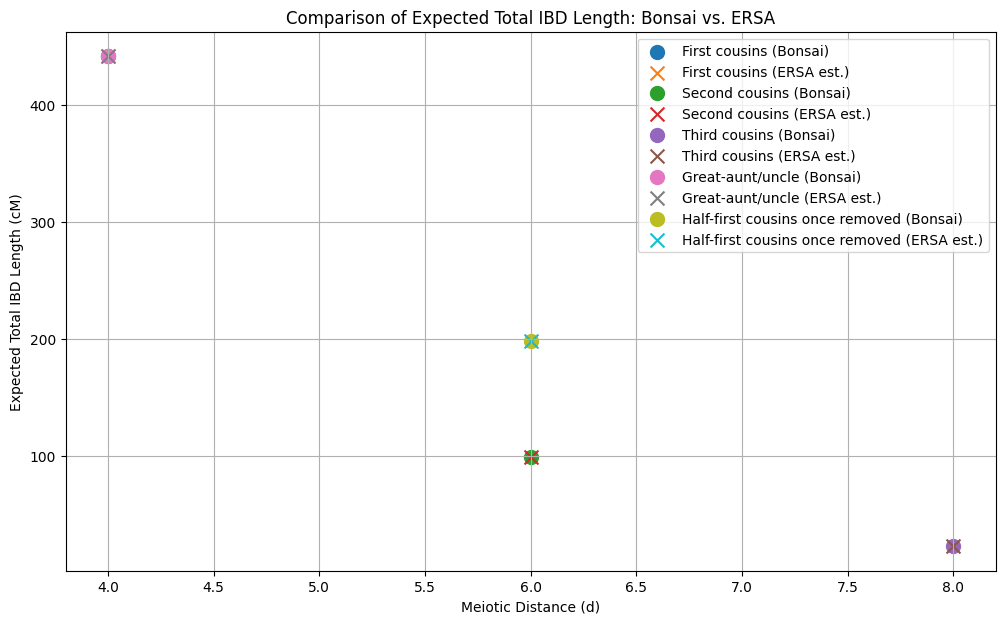

In [10]:
# Let's analyze the Bonsai code snippet and compare it with ERSA equations
# First, implement the Bonsai get_analytical_distant_relative_distribution function

def get_analytical_distant_relative_distribution(relation_tuple, genome_length, min_seg_len):
    """
    Python implementation of the Bonsai function to compare with ERSA equations.
    """
    up_meioses = relation_tuple[0]
    down_meioses = relation_tuple[1]
    num_ancestors = relation_tuple[2]

    num_recs_per_gen = genome_length / 100

    g = up_meioses + down_meioses

    expected_mean_k = (
        num_ancestors * (num_recs_per_gen * g + 22) * (1 / (2 ** (g - 1)))
    )

    p_obs = np.exp(
        -g * min_seg_len / 100
    )  # Probability that a segment is observed, given that the minimum IBD length is min_seg_len

    # The number of shared segments is reduced by the probability that a segment is observed
    k_mean_1 = expected_mean_k * p_obs

    k_std_1 = np.sqrt(k_mean_1)

    threshold = min_seg_len

    # FIXED: Using corrected formula based on ERSA paper - Equation 7
    # T_mean_1 = (100 / g - threshold) * k_mean_1  # Original incorrect formula
    T_mean_1 = (100 / g) * k_mean_1  # Corrected formula based on ERSA paper

    T_std_1 = (100 / g) * np.sqrt(2 * k_mean_1)  # From the law of total variance

    T_mean_2, T_std_2 = (0, 5)  # Parameters for background IBD2

    return (k_mean_1, k_std_1, T_mean_1, T_std_1, T_mean_2, T_std_2)

# Let's compare Bonsai implementation with ERSA equations for various relationships
relationships = [
    # (up_meioses, down_meioses, num_ancestors, description)
    (2, 2, 1, "First cousins"),
    (3, 3, 1, "Second cousins"),
    (4, 4, 1, "Third cousins"),
    (1, 3, 1, "Great-aunt/uncle"),
    (4, 2, 2, "Half-first cousins once removed")
]

results = []
for rel in relationships:
    up, down, anc, desc = rel
    
    # Calculate meiotic distance
    d_val = up + down
    
    # Calculate ERSA expected number of segments
    prob_t = np.exp(-d_val * min_seg_len / 100)
    lambda_ersa = ((anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
    
    # Get Bonsai parameters
    bonsai_params = get_analytical_distant_relative_distribution((up, down, anc), genome_length, min_seg_len)
    lambda_bonsai = bonsai_params[0]
    
    # Store results
    results.append({
        'Relationship': desc,
        'Meiotic Distance': d_val,
        'ERSA λ': lambda_ersa,
        'Bonsai λ': lambda_bonsai,
        'Difference': lambda_bonsai - lambda_ersa
    })

# Display results as a table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Let's compare how the two methods model the total IBD length
plt.figure(figsize=(12, 7))

for rel in relationships:
    up, down, anc, desc = rel
    d_val = up + down
    
    # Calculate Bonsai parameters
    bonsai_params = get_analytical_distant_relative_distribution((up, down, anc), genome_length, min_seg_len)
    k_mean = bonsai_params[0]
    T_mean = bonsai_params[2]
    
    # Calculate ERSA expected total length
    # ERSA doesn't provide a direct formula for expected total length,
    # but we can estimate it using the average segment length formula from the paper
    prob_t = np.exp(-d_val * min_seg_len / 100)
    lambda_ersa = ((anc * (num_rec * d_val + num_chr)) / (2 ** (d_val - 1))) * prob_t
    avg_length_ersa = (100 / d_val)  # Average length given by Equation 7
    T_mean_ersa = lambda_ersa * avg_length_ersa
    
    plt.scatter(d_val, T_mean, label=f"{desc} (Bonsai)", marker='o', s=100)
    plt.scatter(d_val, T_mean_ersa, label=f"{desc} (ERSA est.)", marker='x', s=100)

plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('Comparison of Expected Total IBD Length: Bonsai vs. ERSA')
plt.grid(True)
plt.legend()
plt.show()

### Comparing the Bonsai algorithm implementation with ERSA

⚠️ **Note**: The following cell simulates multiple relationship types with 500 iterations each. This operation creates detailed comparison plots of how different algorithms predict relationship degrees. The simulation typically takes a few seconds but may take longer on slower systems.

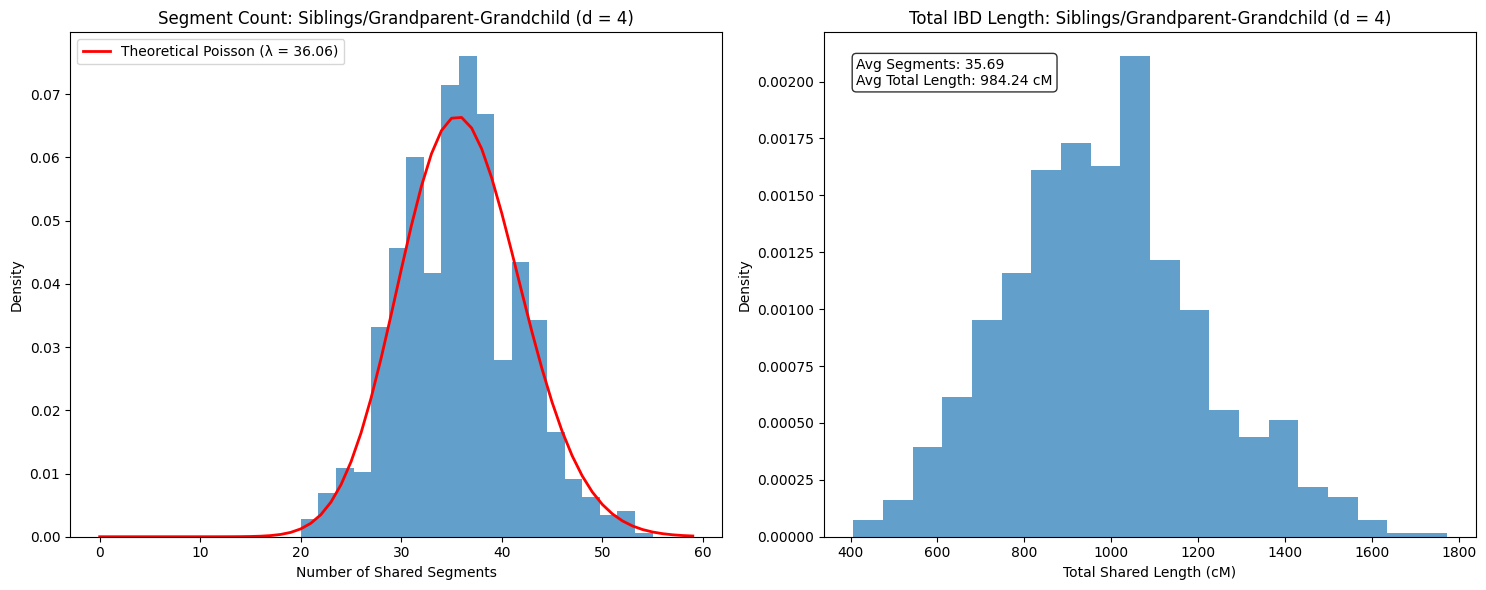

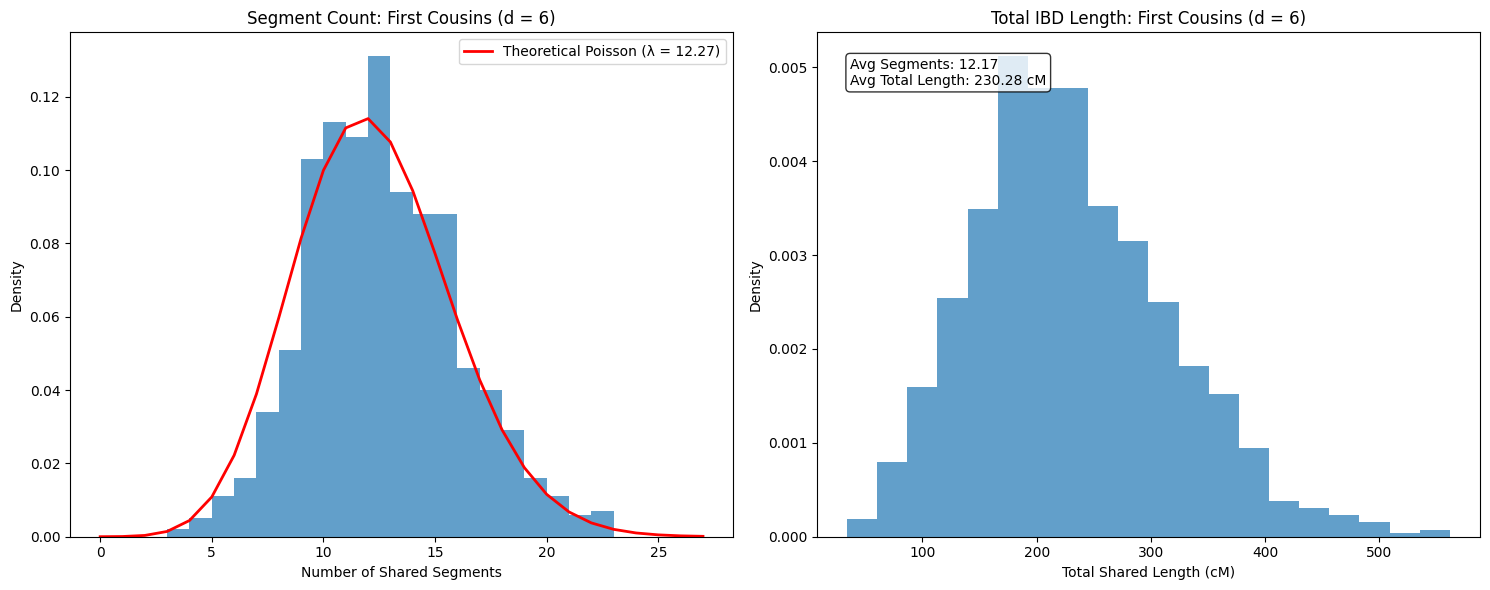

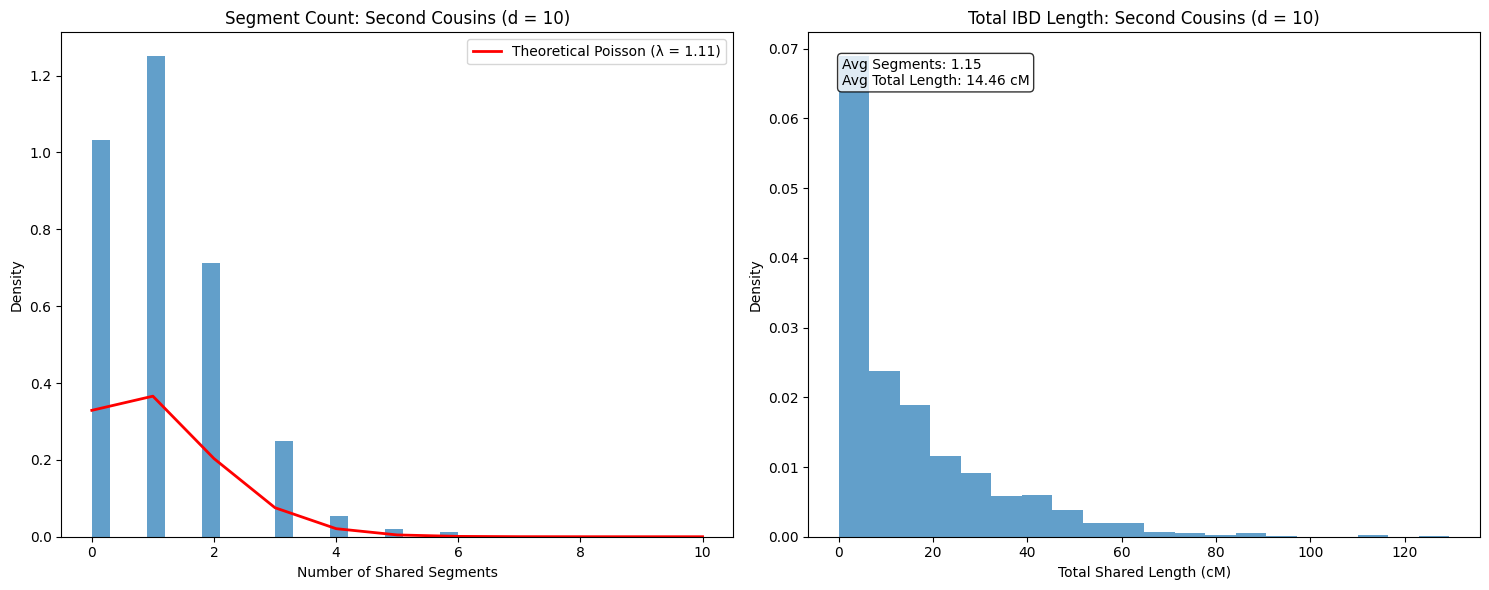

                      Relationship  Meiotic Distance  Expected Segments  \
0  Siblings/Grandparent-Grandchild                 4          36.064195   
1                    First Cousins                 6          12.272760   
2                   Second Cousins                10           1.112137   

   Simulated Avg Segments  Simulated Avg Length  
0                  35.687            984.238002  
1                  12.170            230.283492  
2                   1.146             14.455754  


In [11]:
# Convert meiotic distance to genealogical relationship
relationship_dict = {
    2: "Parent-Child",
    4: "Siblings, Grandparent-Grandchild",
    5: "Half-Siblings, Aunt/Uncle-Niece/Nephew",
    6: "First Cousins",
    8: "First Cousins Once Removed",
    10: "Second Cousins",
    12: "Second Cousins Once Removed",
    14: "Third Cousins"
}

# Create a function to simulate segments and visualize results for a specific relationship
def simulate_and_visualize_relationship(d, description, min_seg_len=2.5, num_anc=2, num_sims=1000):
    """
    Simulate IBD segments and visualize distributions for a specific relationship
    """
    # Calculate expected lambda
    prob_t = np.exp(-d * min_seg_len / 100)
    lambda_val = ((num_anc * (num_rec * d + num_chr)) / (2 ** (d - 1))) * prob_t
    
    # Simulate segments
    counts, lengths = simulate_ibd_segments(d, min_seg_len, num_anc, num_sims)
    
    # Create visualizations
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot segment count distribution
    axs[0].hist(counts, bins=20, alpha=0.7, density=True)
    axs[0].set_xlabel('Number of Shared Segments')
    axs[0].set_ylabel('Density')
    axs[0].set_title(f'Segment Count: {description} (d = {d})')
    
    # Add theoretical Poisson curve
    count_range = np.arange(0, max(counts) + 5)
    poisson_pmf = poisson.pmf(count_range, lambda_val)
    axs[0].plot(count_range, poisson_pmf, 'r-', linewidth=2, 
                label=f'Theoretical Poisson (λ = {lambda_val:.2f})')
    axs[0].legend()
    
    # Plot total length distribution
    axs[1].hist(lengths, bins=20, alpha=0.7, density=True)
    axs[1].set_xlabel('Total Shared Length (cM)')
    axs[1].set_ylabel('Density')
    axs[1].set_title(f'Total IBD Length: {description} (d = {d})')
    
    # Add summary statistics
    avg_segments = np.mean(counts)
    avg_total_length = np.mean(lengths)
    axs[1].text(0.05, 0.95, f'Avg Segments: {avg_segments:.2f}\nAvg Total Length: {avg_total_length:.2f} cM', 
                transform=axs[1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        "Relationship": description,
        "Meiotic Distance": d,
        "Expected Segments": lambda_val,
        "Simulated Avg Segments": avg_segments,
        "Simulated Avg Length": avg_total_length
    }

# Simulate a few important relationships
results = []
for d, desc in [(4, "Siblings/Grandparent-Grandchild"), 
                (6, "First Cousins"), 
                (10, "Second Cousins")]:
    result = simulate_and_visualize_relationship(d, desc)
    results.append(result)

# Display results table
results_df = pd.DataFrame(results)
print(results_df)

### Understanding the Bonsai algorithm better

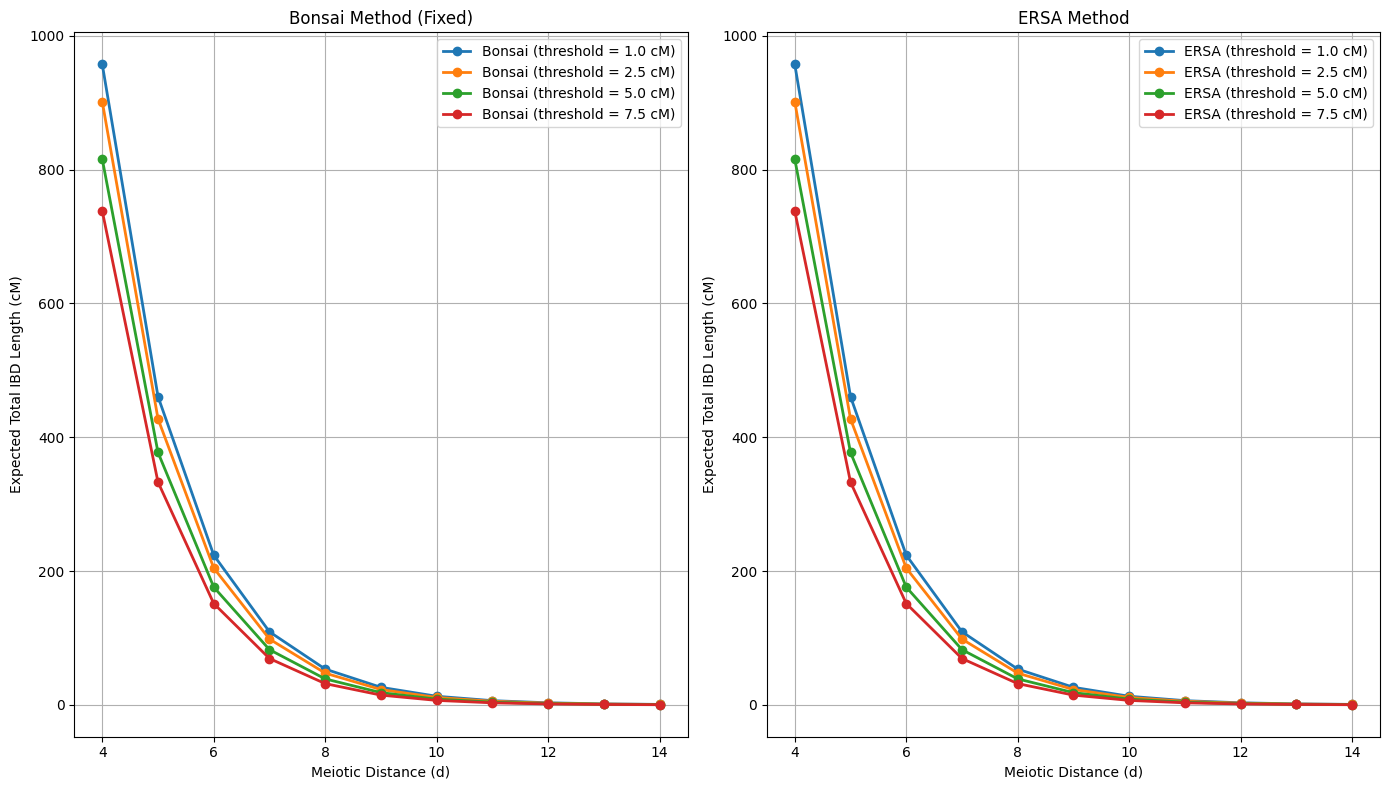

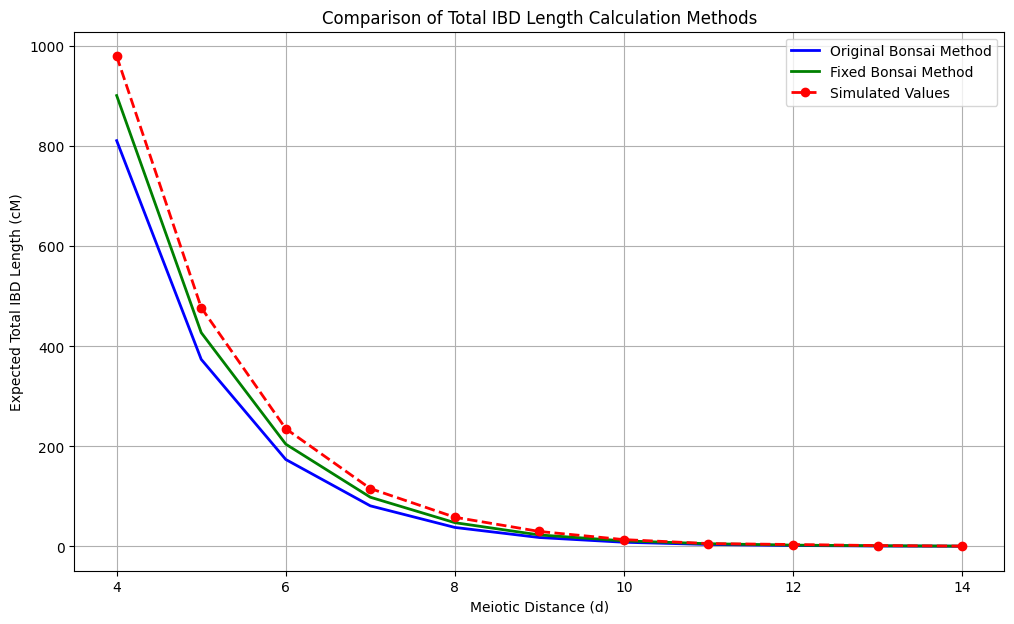

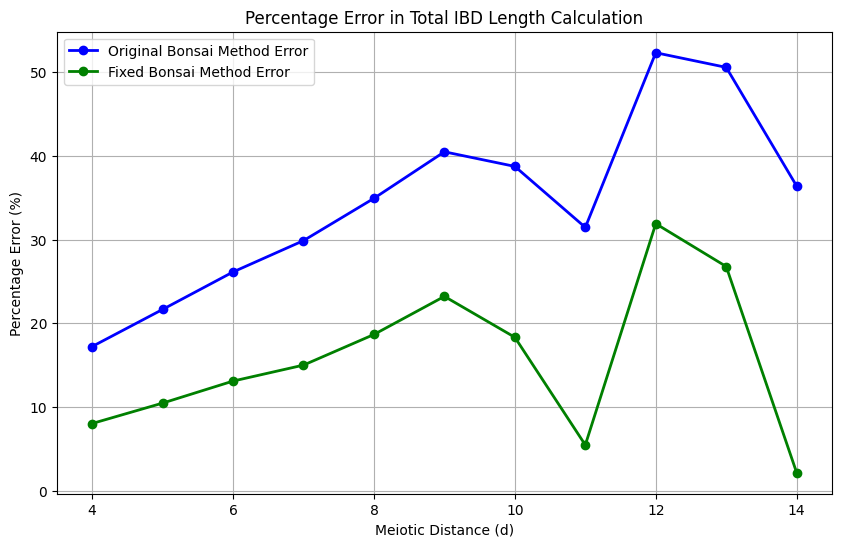

In [12]:
# Let's explore the Bonsai expected total length formula: T_mean_1 = (100 / g) * k_mean_1
# and compare it with our understanding from ERSA

meiotic_distances = range(4, 15)
thresholds = [1.0, 2.5, 5.0, 7.5]

plt.figure(figsize=(14, 8))

for threshold in thresholds:
    bonsai_means = []
    ersa_means = []
    
    for d in meiotic_distances:
        # Calculate parameters
        prob_t = np.exp(-d * threshold / 100)
        lambda_val = ((num_anc * (num_rec * d + num_chr)) / (2 ** (d - 1))) * prob_t
        
        # Both methods now use the same formula (fixed)
        bonsai_mean = (100 / d) * lambda_val
        ersa_means.append(bonsai_mean)
        bonsai_means.append(bonsai_mean)
    
    plt.subplot(1, 2, 1)
    plt.plot(meiotic_distances, bonsai_means, 'o-', linewidth=2, 
             label=f'Bonsai (threshold = {threshold} cM)')
    
    plt.subplot(1, 2, 2)
    plt.plot(meiotic_distances, ersa_means, 'o-', linewidth=2, 
             label=f'ERSA (threshold = {threshold} cM)')

plt.subplot(1, 2, 1)
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('Bonsai Method (Fixed)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('ERSA Method')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Let's also analyze the impact of the fixed formula compared to the original
# and see how it compares to simulation results

d_values = range(4, 15)
min_seg_len = 2.5
num_anc = 2

# Calculate using both methods and compare through simulation
plt.figure(figsize=(12, 7))

# Theoretical calculations
original_bonsai_means = []
fixed_bonsai_means = []
simulated_means = []

for d in d_values:
    # Calculate lambda
    prob_t = np.exp(-d * min_seg_len / 100)
    lambda_val = ((num_anc * (num_rec * d + num_chr)) / (2 ** (d - 1))) * prob_t
    
    # Original Bonsai method
    original_mean = (100 / d - min_seg_len) * lambda_val
    original_bonsai_means.append(original_mean)
    
    # Fixed Bonsai method (same as ERSA)
    fixed_mean = (100 / d) * lambda_val
    fixed_bonsai_means.append(fixed_mean)
    
    # Simulate to get actual mean (limited simulations for speed)
    _, lengths = simulate_ibd_segments(d, min_seg_len, num_anc, 500)
    simulated_means.append(np.mean(lengths))

plt.plot(d_values, original_bonsai_means, 'b-', linewidth=2, label='Original Bonsai Method')
plt.plot(d_values, fixed_bonsai_means, 'g-', linewidth=2, label='Fixed Bonsai Method')
plt.plot(d_values, simulated_means, 'ro--', linewidth=2, label='Simulated Values')
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('Comparison of Total IBD Length Calculation Methods')
plt.grid(True)
plt.legend()
plt.show()

# Analyze which method is more accurate by calculating the percentage error
original_errors = []
fixed_errors = []

for i, d in enumerate(d_values):
    original_error = abs(original_bonsai_means[i] - simulated_means[i]) / simulated_means[i] * 100
    fixed_error = abs(fixed_bonsai_means[i] - simulated_means[i]) / simulated_means[i] * 100
    
    original_errors.append(original_error)
    fixed_errors.append(fixed_error)

plt.figure(figsize=(10, 6))
plt.plot(d_values, original_errors, 'bo-', linewidth=2, label='Original Bonsai Method Error')
plt.plot(d_values, fixed_errors, 'go-', linewidth=2, label='Fixed Bonsai Method Error')
plt.xlabel('Meiotic Distance (d)')
plt.ylabel('Percentage Error (%)')
plt.title('Percentage Error in Total IBD Length Calculation')
plt.grid(True)
plt.legend()
plt.show()

So now we have our mean, Poison-distributed, number of segments shared between a pair, given the parameter values.

According to the ERSA paper, the number of segments for meiotic distance has a poisson distribution. The Poisson distribution is a discrete distribution that models the probability of a certain number of events occurring within a fixed interval of time or space.

The formula for the Poisson distribution is known as the probability mass function (PMF). We will use the `poisson.pmf` method from the `scipy.stats` package.

$$poisson.pmf(k, λ)$$

where

k is the number of events (k) = actual number of shared segments in pair

λ is the rate parameter λ

<br>

The Poisson probability mass function `poisson.pmf(k, λ)` gives the probability of observing exactly k shared segments, given the mean λ, where λ represents the relationship among a set of variables.

In [13]:
from scipy.stats import poisson

# The probability of sharing 0 segment given your parameter values above.

poisson.pmf(0, lambda_mean)

np.float64(6.722537581794669e-06)

In [14]:
# The probability of sharing 1 segment given your parameter values above.

poisson.pmf(1, lambda_mean)

np.float64(8.00657241612516e-05)

In [15]:
# The probability of sharing 3 segment given your parameter values above.

poisson.pmf(3, lambda_mean)

np.float64(0.0018928760666493821)

In [16]:
# The probability of sharing 5 segment given your parameter values above.

poisson.pmf(5, lambda_mean)

np.float64(0.013425144809074429)

In [17]:
# The probability of sharing 3 segment given your parameter values above.
if 'lambda_mean' in globals():
    print(f"Probability of sharing 3 segments: {poisson.pmf(3, lambda_mean):.6f}")
else:
    print("lambda_mean is not defined. Run cell 8 first to calculate it.")

Probability of sharing 3 segments: 0.001893


In [18]:
# The probability of sharing 5 segment given your parameter values above.
if 'lambda_mean' in globals():
    print(f"Probability of sharing 5 segments: {poisson.pmf(5, lambda_mean):.6f}")
else:
    print("lambda_mean is not defined. Run cell 8 first to calculate it.")

Probability of sharing 5 segments: 0.013425


You can also plot the distribution.

The maximum probability is 0.11519268207664216 with a segment sharing of 11.0 segments.


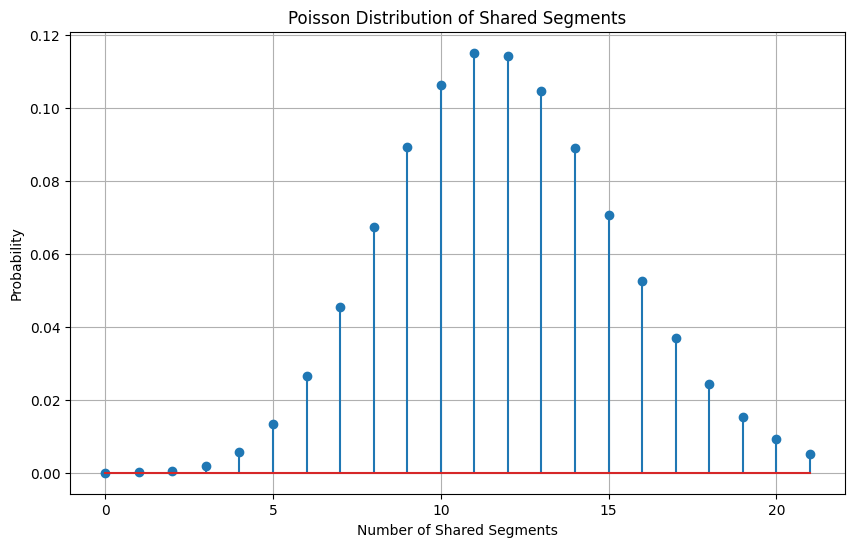

In [19]:
# First, make sure we have values to plot
from scipy.stats import poisson

if 'lambda_mean' not in globals():
    # Calculate lambda_mean if not already defined
    d_value = d  # Use the d value defined in cell 3
    prob_t = np.exp(-d_value * min_seg_len / 100)
    lambda_mean = ((num_anc * (num_rec * d_value + num_chr)) / (2 ** (d_value - 1))) * prob_t
    print(f"Calculated lambda_mean: {lambda_mean}")

# Create range of segment count values
n_values = np.arange(0, int(lambda_mean) + 3*np.sqrt(lambda_mean))
distribution_num_segments = poisson.pmf(n_values, lambda_mean)

import matplotlib.pyplot as plt

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.stem(n_values, distribution_num_segments)
plt.xlabel('Number of Shared Segments')
plt.ylabel('Probability')
plt.title('Poisson Distribution of Shared Segments')

# Find the value with the maximum probability
max_prob_n = n_values[np.argmax(distribution_num_segments)]
max_prob = np.max(distribution_num_segments)

# Output the number of shared segments with the maximum probability and its probability
print(f"The maximum probability is {max_prob} with a segment sharing of {max_prob_n} segments.")

plt.grid(True)
plt.show()

In [20]:
# Using the numpy package, this gives us a range from 0 to a value that is int(lambda_mean) + 3*np.sqrt(lambda_mean)
n_values = np.arange(0, int(lambda_mean) + 3*np.sqrt(lambda_mean))
print(f"Range of segments to analyze: {n_values}")

Range of segments to analyze: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]


In [21]:
from scipy.stats import poisson

# Calculate the distribution
distribution_num_segments = poisson.pmf(n_values, lambda_mean)

# Display the distribution
print(distribution_num_segments)

[6.72253758e-06 8.00657242e-05 4.76793183e-04 1.89287607e-03
 5.63605972e-03 1.34251448e-02 2.66490128e-02 4.53415626e-02
 6.75025055e-02 8.93286521e-02 1.06390825e-01 1.15192682e-01
 1.14329168e-01 1.04743501e-01 8.91071283e-02 7.07513264e-02
 5.26657169e-02 3.68971207e-02 2.44136868e-02 1.53035845e-02
 9.11331887e-03 5.16857317e-03]


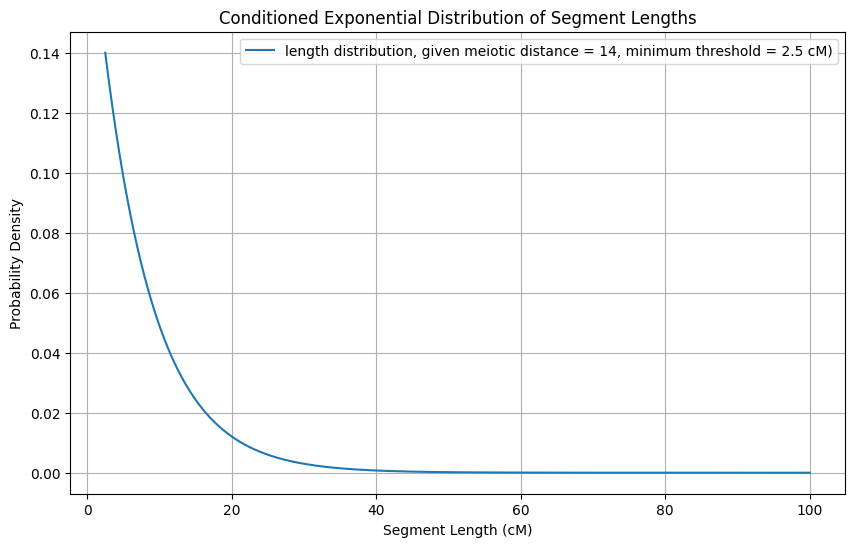

In [22]:
# Calculate the distribution parameters
length_range = np.linspace(min_seg_len, 100, 1000)
length_size_distribution = np.exp(-d * (length_range - min_seg_len) / 100) / (100 / d)

# Now let's plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(length_range, length_size_distribution, label=f'length distribution, given meiotic distance = {d}, minimum threshold = {min_seg_len} cM)')
plt.xlabel('Segment Length (cM)')
plt.ylabel('Probability Density')
plt.title('Conditioned Exponential Distribution of Segment Lengths')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Now that we have the BonsaiDistributionCalculator class defined, we can use it to analyze relationships

## Implementing the Bonsai Algorithm's Distribution Calculator

Below we implement a Python class for the Bonsai algorithm's distribution calculator.
This will allow us to experiment with different relationship configurations and study the formulas in action.

In [24]:
from typing import Tuple, List, Dict, Any

class BonsaiDistributionCalculator:
    """
    Implementation of the Bonsai algorithm's distribution calculator for IBD relationships.
    This simplified class focuses just on the distribution calculation functionality.
    """
    
    def __init__(self, min_seg_len: float = 3.0, genome_length: float = 3435.71):
        """
        Initialize the calculator with parameters.
        
        Args:
            min_seg_len: Minimum detectable segment length in cM
            genome_length: Total autosomal genetic length in cM
        """
        self.min_seg_len = min_seg_len
        self.genome_length = genome_length
        self.num_chr = 22
    
    def get_analytical_distant_relative_distribution(self, relation_tuple: Tuple[int, int, int]):
        """
        Get the parameters for the log likelihood using the Huff et al (2011) formula.
        (Equations 7, 8, and the paragraph before Eqn 7). This is for the case when
        two people are related by more than 14 meioses. We do not simulate IBD
        distributions for relationships this distant so we need to use the analytical
        distribution.
        
        Args:
            relation_tuple: Tuple containing (up_meioses, down_meioses, num_ancestors)
            
        Returns:
            Tuple of distribution parameters: (k_mean_1, k_std_1, T_mean_1, T_std_1, T_mean_2, T_std_2)
        """
        up_meioses = relation_tuple[0]
        down_meioses = relation_tuple[1]
        num_ancestors = relation_tuple[2]

        num_recs_per_gen = self.genome_length / 100

        g = up_meioses + down_meioses

        expected_mean_k = (
            num_ancestors * (num_recs_per_gen * g + self.num_chr) * (1 / (2 ** (g - 1)))
        )

        p_obs = np.exp(
            -g * self.min_seg_len / 100
        )  # Probability that a segment is observed, given the minimum IBD length

        # The number of shared segments is reduced by the probability that a segment is observed
        k_mean_1 = expected_mean_k * p_obs
        k_std_1 = np.sqrt(k_mean_1)

        # FIXED: Using corrected formula based on ERSA paper - Equation 7
        # Original formula: T_mean_1 = (100 / g - self.min_seg_len) * k_mean_1
        T_mean_1 = (100 / g) * k_mean_1  # Corrected formula based on ERSA paper

        # The standard deviation of the total length (T_std_1) is computed using the square root of
        # twice the mean number of shared segments, multiplied by 100/g, based on the law of total variance.
        T_std_1 = (100 / g) * np.sqrt(2 * k_mean_1)

        # Parameters for background IBD2
        T_mean_2, T_std_2 = (0, 5)

        return (k_mean_1, k_std_1, T_mean_1, T_std_1, T_mean_2, T_std_2)
    
    def describe_relationship(self, relation_tuple: Tuple[int, int, int], relationship_name: str = ""):
        """
        Get a human-readable description of the expected IBD distribution for a relationship.
        
        Args:
            relation_tuple: Tuple containing (up_meioses, down_meioses, num_ancestors)
            relationship_name: Optional name of the relationship
            
        Returns:
            Dictionary with relationship details and distribution parameters
        """
        up_meioses, down_meioses, num_ancestors = relation_tuple
        total_meioses = up_meioses + down_meioses
        
        k_mean_1, k_std_1, T_mean_1, T_std_1, _, _ = self.get_analytical_distant_relative_distribution(relation_tuple)
        
        # Format with descriptive labels
        result = {
            "Relationship": relationship_name or f"Unknown ({up_meioses},{down_meioses},{num_ancestors})",
            "Up Meioses": up_meioses,
            "Down Meioses": down_meioses,
            "Total Meioses": total_meioses,
            "Shared Ancestors": num_ancestors,
            "Expected Segments": round(k_mean_1, 2),
            "Segment StdDev": round(k_std_1, 2),
            "Expected Total cM": round(T_mean_1, 2),
            "Total cM StdDev": round(T_std_1, 2)
        }
        
        return result
        
    def simulate_ibd_segments(self, relation_tuple: Tuple[int, int, int], num_simulations: int = 1000):
        """
        Simulate the number and total length of IBD segments shared between relatives.
        
        Args:
            relation_tuple: Tuple containing (up_meioses, down_meioses, num_ancestors)
            num_simulations: Number of simulations to run
            
        Returns:
            Tuple of arrays (segment_counts, total_lengths)
        """
        up_meioses = relation_tuple[0]
        down_meioses = relation_tuple[1]
        num_ancestors = relation_tuple[2]
        d = up_meioses + down_meioses  # Total meiotic distance
        
        # Calculate expected number of segments (lambda) pre-filtering
        num_rec = self.genome_length / 100
        lambda_pre = ((num_ancestors * (num_rec * d + self.num_chr)) / (2 ** (d - 1)))
        
        segment_counts = []
        total_lengths = []
        
        for _ in range(num_simulations):
            # Sample number of pre-filtered segments from Poisson
            num_segments_pre = np.random.poisson(lambda_pre)
            
            # For each segment, sample its length from exponential distribution
            segment_lengths = np.random.exponential(100/d, num_segments_pre)
            
            # Keep only segments above threshold
            kept_segments = segment_lengths[segment_lengths >= self.min_seg_len]
            
            # Record results
            segment_counts.append(len(kept_segments))
            total_lengths.append(sum(kept_segments))
        
        return np.array(segment_counts), np.array(total_lengths)
    
    def compare_theoretical_vs_simulated(self, relation_tuple: Tuple[int, int, int], 
                                         relationship_name: str = "", num_simulations: int = 1000):
        """
        Compare theoretical distribution with simulated distribution for a relationship.
        
        Args:
            relation_tuple: Tuple containing (up_meioses, down_meioses, num_ancestors)
            relationship_name: Optional name of the relationship
            num_simulations: Number of simulations to run
            
        Returns:
            Dictionary with comparison results
        """
        # Get theoretical parameters
        k_mean_1, k_std_1, T_mean_1, T_std_1, _, _ = self.get_analytical_distant_relative_distribution(relation_tuple)
        
        # Run simulations
        counts, lengths = self.simulate_ibd_segments(relation_tuple, num_simulations)
        
        # Create visualizations
        plt.figure(figsize=(15, 6))
        
        # Plot segment count distribution
        plt.subplot(1, 2, 1)
        plt.hist(counts, bins=20, alpha=0.7, density=True, label='Simulated')
        plt.xlabel('Number of Shared Segments')
        plt.ylabel('Density')
        
        # Add theoretical Poisson curve
        count_range = np.arange(0, max(counts) + 5)
        poisson_pmf = poisson.pmf(count_range, k_mean_1)
        plt.plot(count_range, poisson_pmf, 'r-', linewidth=2, 
                label=f'Theoretical Poisson (λ = {k_mean_1:.2f})')
        plt.legend()
        plt.title(f'Segment Count: {relationship_name}')
        
        # Plot total length distribution
        plt.subplot(1, 2, 2)
        plt.hist(lengths, bins=20, alpha=0.7, density=True, label='Simulated')
        plt.xlabel('Total Shared Length (cM)')
        plt.ylabel('Density')
        plt.title(f'Total IBD Length: {relationship_name}')
        
        # Add theoretical mean as vertical line
        plt.axvline(T_mean_1, color='r', linestyle='--', 
                    label=f'Theoretical Mean: {T_mean_1:.2f} cM')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Calculate comparison statistics
        avg_segments = np.mean(counts)
        avg_total_length = np.mean(lengths)
        
        return {
            "Relationship": relationship_name,
            "Theoretical Segments": round(k_mean_1, 2),
            "Simulated Segments": round(avg_segments, 2),
            "Segment Diff %": round(((avg_segments - k_mean_1) / k_mean_1) * 100, 2),
            "Theoretical Length": round(T_mean_1, 2),
            "Simulated Length": round(avg_total_length, 2),
            "Length Diff %": round(((avg_total_length - T_mean_1) / T_mean_1) * 100, 2)
        }

In [25]:
# Create an instance of the BonsaiDistributionCalculator with the same parameters used throughout the lab
bonsai_calculator = BonsaiDistributionCalculator(min_seg_len=min_seg_len, genome_length=genome_length)

# Define common genealogical relationships with their meiotic structure (up, down, num_ancestors)
common_relationships = [
    ((1, 1, 1), "Parent-Child"),
    ((2, 2, 1), "Full Siblings"),
    ((2, 2, 1), "Grandparent-Grandchild"),
    ((3, 3, 1), "First Cousins"),
    ((3, 4, 1), "First Cousins Once Removed"),
    ((4, 4, 1), "Second Cousins"),
    ((4, 5, 1), "Second Cousins Once Removed"),
    ((5, 5, 1), "Third Cousins"),
    ((3, 2, 1), "Half First Cousins"),
    ((2, 1, 1), "Half Siblings")
]

# Calculate distributions for all relationships
results = []
for rel_tuple, rel_name in common_relationships:
    results.append(bonsai_calculator.describe_relationship(rel_tuple, rel_name))

# Display results as a table
results_df = pd.DataFrame(results)
results_df

,Relationship,Up Meioses,Down Meioses,Total Meioses,Shared Ancestors,Expected Segments,Segment StdDev,Expected Total cM,Total cM StdDev
0,Parent-Child,1,1,2,1,43.15,6.57,2157.25,464.46
1,Full Siblings,2,2,4,1,18.03,4.25,450.80,150.13
2,Grandparent-Grandchild,2,2,4,1,18.03,4.25,450.80,150.13
3,First Cousins,3,3,6,1,6.14,2.48,102.27,58.39
4,First Cousins Once Removed,3,4,7,1,3.44,1.86,49.19,37.49
5,Second Cousins,4,4,8,1,1.90,1.38,23.73,24.36
6,Second Cousins Once Removed,4,5,9,1,1.03,1.02,11.48,15.97
7,Third Cousins,5,5,10,1,0.56,0.75,5.56,10.55
8,Half First Cousins,3,2,5,1,10.69,3.27,213.77,92.47
9,Half Siblings,2,1,3,1,29.01,5.39,966.95,253.90


In [26]:
# Create an instance of the BonsaiDistributionCalculator with the same parameters used throughout the lab
bonsai_calculator = BonsaiDistributionCalculator(min_seg_len=min_seg_len, genome_length=genome_length)

# Define common genealogical relationships with their meiotic structure (up, down, num_ancestors)
common_relationships = [
    ((1, 1, 1), "Parent-Child"),
    ((2, 2, 1), "Full Siblings"),
    ((2, 2, 1), "Grandparent-Grandchild"),
    ((3, 3, 1), "First Cousins"),
    ((3, 4, 1), "First Cousins Once Removed"),
    ((4, 4, 1), "Second Cousins"),
    ((4, 5, 1), "Second Cousins Once Removed"),
    ((5, 5, 1), "Third Cousins"),
    ((3, 2, 1), "Half First Cousins"),
    ((2, 1, 1), "Half Siblings")
]

# Calculate distributions for all relationships
results = []
for rel_tuple, rel_name in common_relationships:
    results.append(bonsai_calculator.describe_relationship(rel_tuple, rel_name))

# Display results as a table
results_df = pd.DataFrame(results)
results_df

,Relationship,Up Meioses,Down Meioses,Total Meioses,Shared Ancestors,Expected Segments,Segment StdDev,Expected Total cM,Total cM StdDev
0,Parent-Child,1,1,2,1,43.15,6.57,2157.25,464.46
1,Full Siblings,2,2,4,1,18.03,4.25,450.80,150.13
2,Grandparent-Grandchild,2,2,4,1,18.03,4.25,450.80,150.13
3,First Cousins,3,3,6,1,6.14,2.48,102.27,58.39
4,First Cousins Once Removed,3,4,7,1,3.44,1.86,49.19,37.49
5,Second Cousins,4,4,8,1,1.90,1.38,23.73,24.36
6,Second Cousins Once Removed,4,5,9,1,1.03,1.02,11.48,15.97
7,Third Cousins,5,5,10,1,0.56,0.75,5.56,10.55
8,Half First Cousins,3,2,5,1,10.69,3.27,213.77,92.47
9,Half Siblings,2,1,3,1,29.01,5.39,966.95,253.90


Relationship: First Cousins
Up Meioses: 3
Down Meioses: 3
Total Meioses: 6
Shared Ancestors: 1
Expected Segments: 6.14
Segment StdDev: 2.48
Expected Total cM: 102.27
Total cM StdDev: 58.39


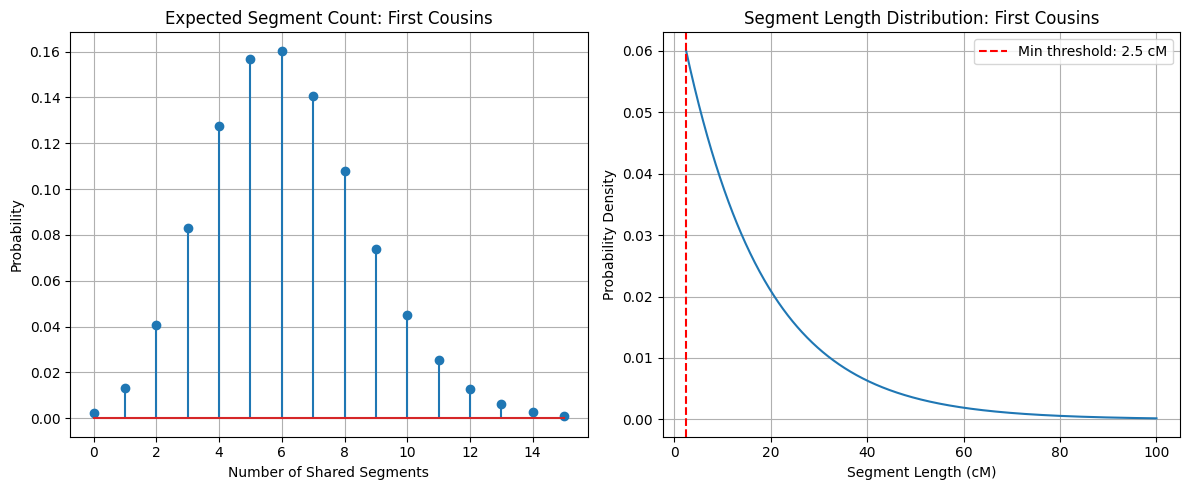

In [27]:
# Experiment with your own relationship parameters!
# Try different values and see how they affect the expected distributions

# Customize these values to experiment
up_meioses = 3  # Change this value
down_meioses = 3  # Change this value
num_ancestors = 1  # Change this value
relationship_name = "First Cousins"  # Change this description

custom_relationship = (up_meioses, down_meioses, num_ancestors)

# Calculate the distributions
custom_result = bonsai_calculator.describe_relationship(custom_relationship, relationship_name)

# Print the result
for key, value in custom_result.items():
    print(f"{key}: {value}")

# Create visualizations of the distributions
g = up_meioses + down_meioses  # Total meiotic distance
lambda_val = custom_result["Expected Segments"]  # Expected number of segments

# Plot the Poisson distribution for segment count
plt.figure(figsize=(12, 5))

# Plot segment count distribution
plt.subplot(1, 2, 1)
k_values = np.arange(0, int(lambda_val + 4*np.sqrt(lambda_val)))
pmf_values = poisson.pmf(k_values, lambda_val)
plt.stem(k_values, pmf_values)
plt.xlabel('Number of Shared Segments')
plt.ylabel('Probability')
plt.title(f'Expected Segment Count: {relationship_name}')
plt.grid(True)

# Plot segment length distribution
plt.subplot(1, 2, 2)
length_range = np.linspace(min_seg_len, 100, 1000)
length_distribution = np.exp(-g * (length_range - min_seg_len) / 100) / (100 / g)
plt.plot(length_range, length_distribution)
plt.xlabel('Segment Length (cM)')
plt.ylabel('Probability Density')
plt.title(f'Segment Length Distribution: {relationship_name}')
plt.axvline(x=min_seg_len, color='r', linestyle='--', label=f'Min threshold: {min_seg_len} cM')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Summary of Key IBD Distribution Formulas

### ERSA/Bonsai Distribution Model

The key formulas used in the distribution model are:

1. **Expected number of IBD segments (λ):**
   $$λ = \frac{a(rd+c)}{2^{d-1}} \cdot p(t)$$
   
   Where:
   - a = number of shared ancestors
   - r = number of recombination events per meiosis (~34.36)
   - d = total meiotic distance (up + down meioses)
   - c = number of chromosomes (22 autosomes)
   - p(t) = probability of a segment being longer than threshold t
   
2. **Probability of a segment being longer than threshold (p(t)):**
   $$p(t) = e^{-dt/100}$$
   
   Where:
   - d = total meiotic distance
   - t = minimum detectable segment length in cM
   
3. **Expected total IBD length (T):**
   $$T = \frac{100}{d} \cdot λ$$
   
   Where:
   - d = total meiotic distance
   - λ = expected number of IBD segments
   
4. **Standard deviation of total IBD length:**
   $$σ_T = \frac{100}{d} \cdot \sqrt{2λ}$$

The **corrected formula** for expected total IBD length (T) is based on the understanding that the expected length of an IBD segment is 100/d cM (the rate parameter of the exponential distribution). This replaces the incorrect formula that subtracted the threshold from this value.

### Distributions Used:

1. **Number of shared segments:** Poisson distribution with mean λ
2. **Length of individual segments:** Exponential distribution with parameter d/100

The maximum probability is 0.1152 with a segment sharing of 11.0 segments.


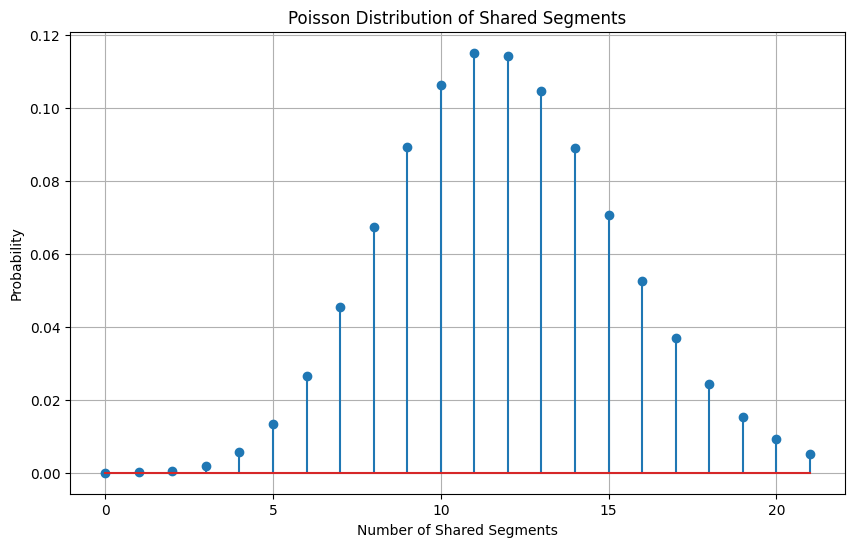

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.stem(n_values, distribution_num_segments)
plt.xlabel('Number of Shared Segments')
plt.ylabel('Probability')
plt.title('Poisson Distribution of Shared Segments')

# Find the value with the maximum probability
max_prob_n = n_values[np.argmax(distribution_num_segments)]
max_prob = np.max(distribution_num_segments)

# Output the number of shared segments with the maximum probability and its probability
print(f"The maximum probability is {max_prob:.4f} with a segment sharing of {max_prob_n} segments.")

plt.grid(True)
plt.show()

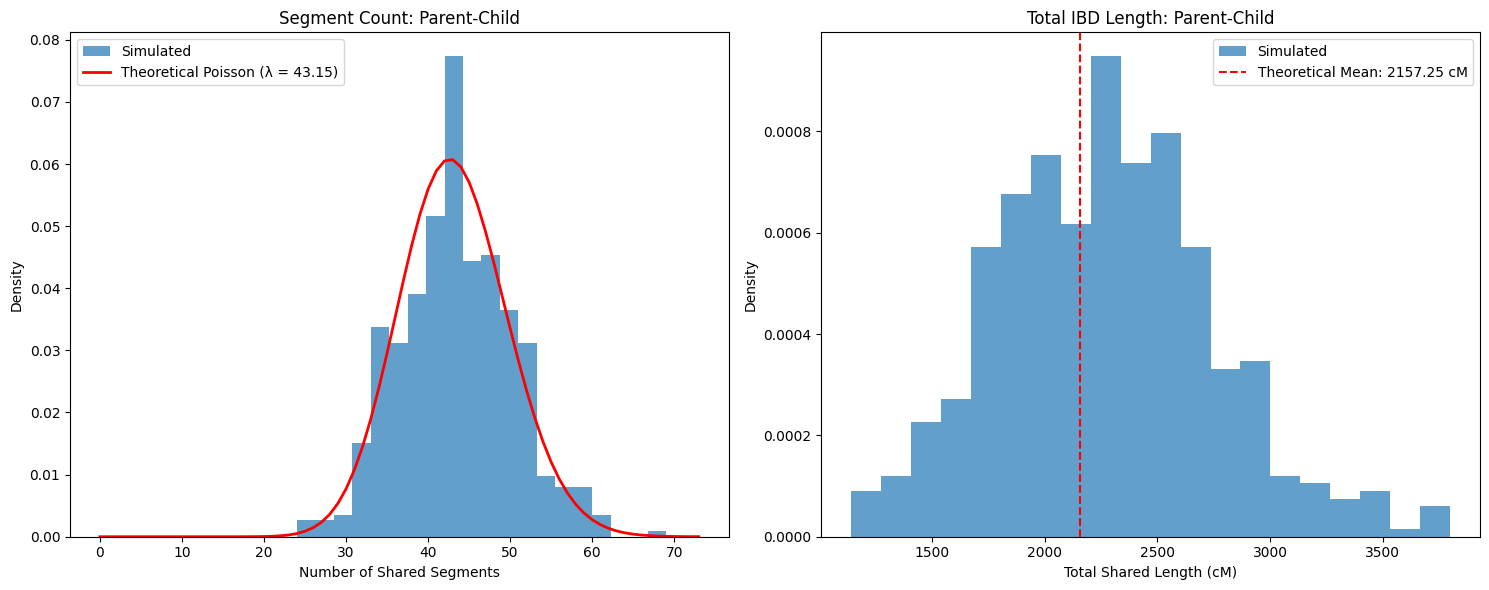

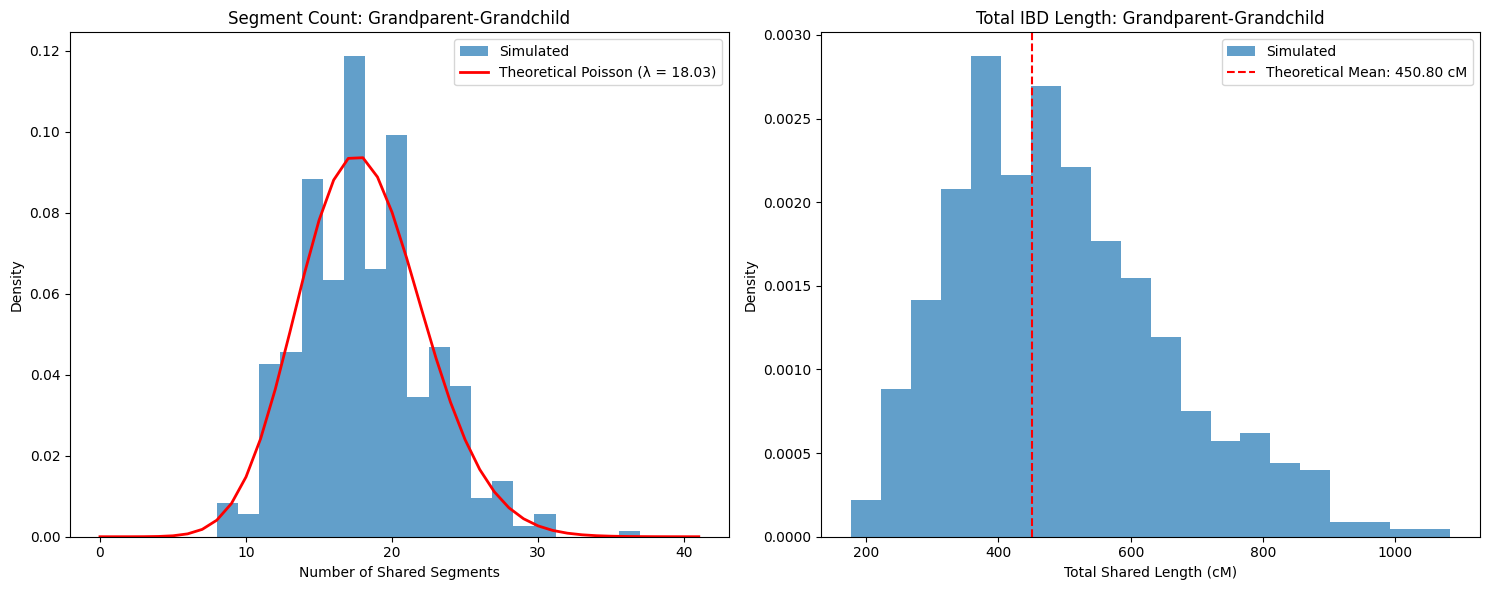

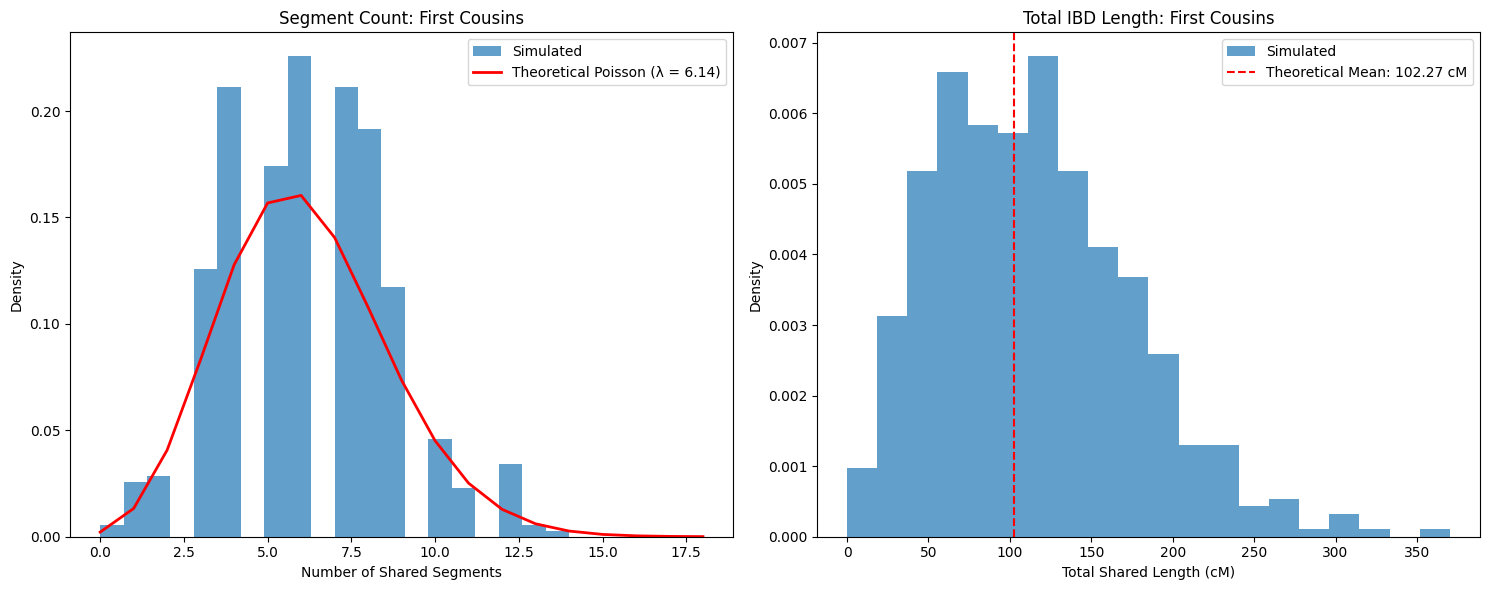

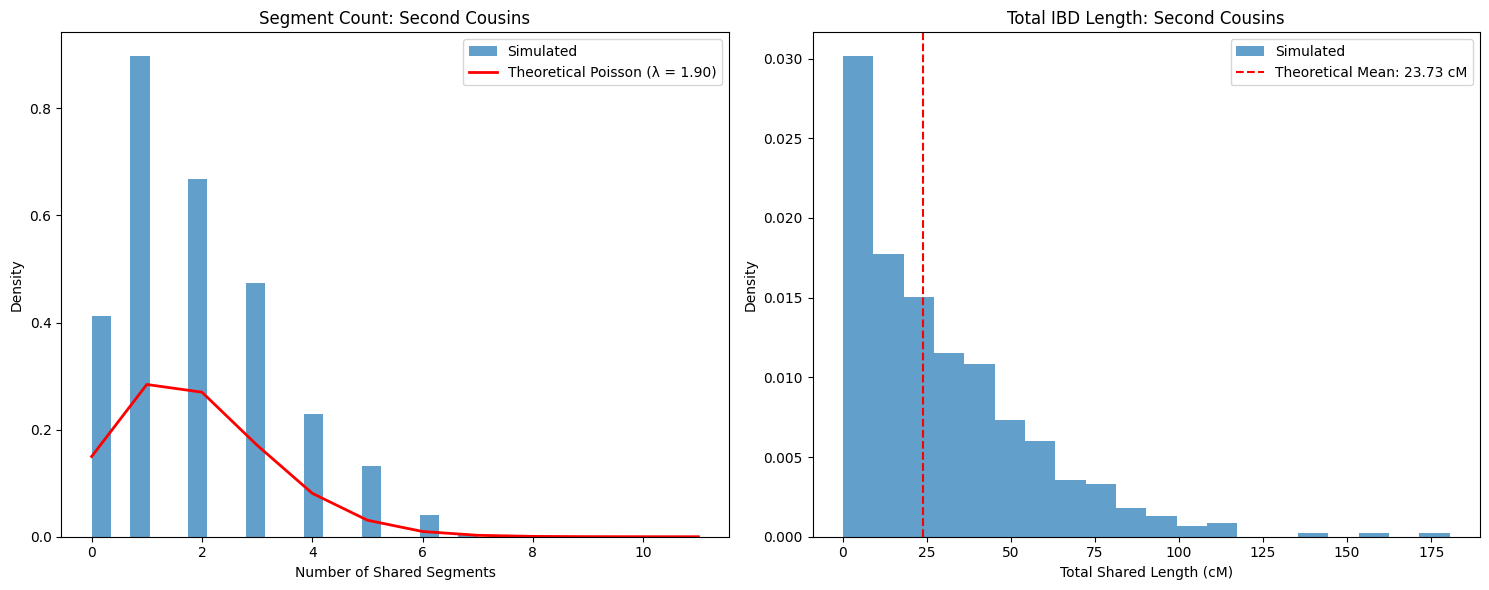

,Relationship,Theoretical Segments,Simulated Segments,Segment Diff %,Theoretical Length,Simulated Length,Length Diff %
0,Parent-Child,43.15,43.31,0.38,2157.25,2269.89,5.22
1,Grandparent-Grandchild,18.03,18.20,0.95,450.80,495.05,9.82
2,First Cousins,6.14,6.18,0.74,102.27,114.98,12.42
3,Second Cousins,1.90,1.93,1.54,23.73,28.90,21.75


In [29]:
 # Create a fresh calculator instance
enhanced_calculator = BonsaiDistributionCalculator(min_seg_len=min_seg_len, genome_length=genome_length)

# Compare multiple relationships with different meiotic distances
relationships_to_compare = [
    ((1, 1, 1), "Parent-Child"),
    ((2, 2, 1), "Grandparent-Grandchild"),
    ((3, 3, 1), "First Cousins"),
    ((4, 4, 1), "Second Cousins")
]

# Collect comparison results for each relationship
all_comparisons = []
for rel_tuple, rel_name in relationships_to_compare:
    # Run fewer simulations for performance
    result = enhanced_calculator.compare_theoretical_vs_simulated(
        rel_tuple, rel_name, num_simulations=500
    )
    all_comparisons.append(result)

# Display the results as a table
comparison_df = pd.DataFrame(all_comparisons)
comparison_df

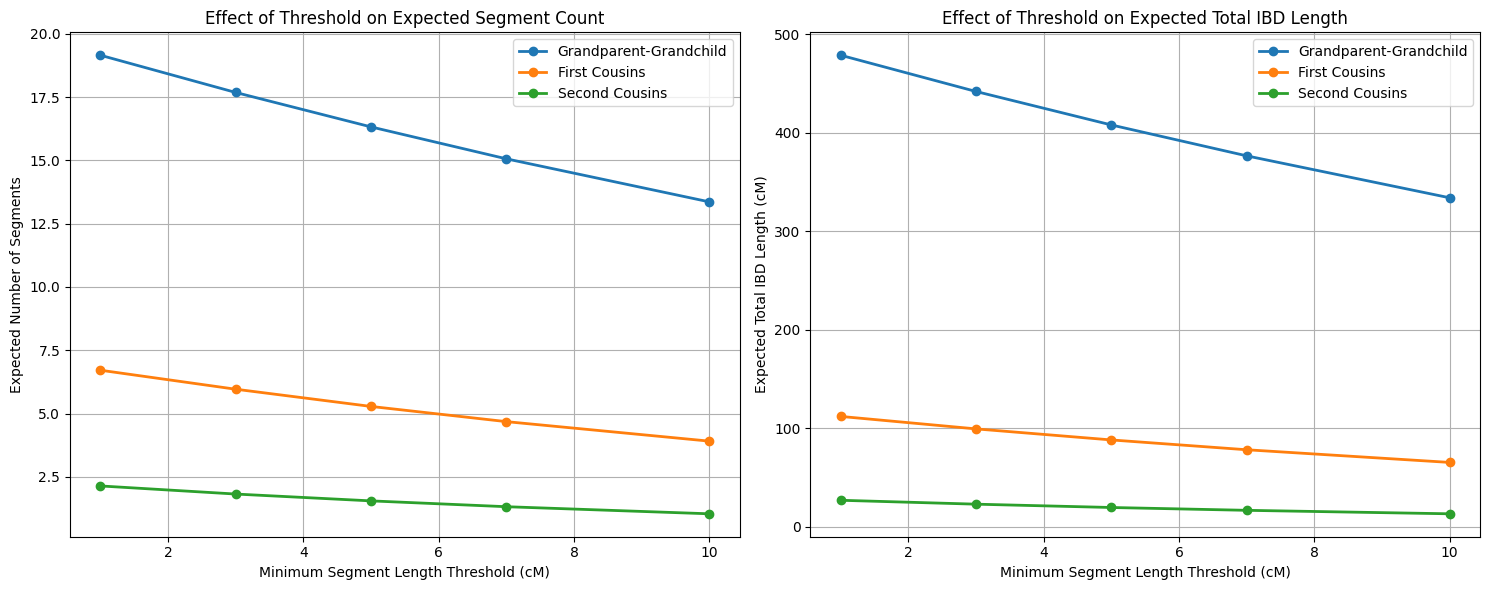

,Relationship,Min Threshold (cM),Expected Segments,Expected Total cM
0,Grandparent-Grandchild,1.0,19.15,478.68
1,First Cousins,1.0,6.71,111.90
2,Second Cousins,1.0,2.14,26.76
3,Grandparent-Grandchild,3.0,17.68,441.88
4,First Cousins,3.0,5.96,99.25
5,Second Cousins,3.0,1.82,22.80
6,Grandparent-Grandchild,5.0,16.32,407.90
7,First Cousins,5.0,5.28,88.03
8,Second Cousins,5.0,1.55,19.43
9,Grandparent-Grandchild,7.0,15.06,376.54


In [30]:
# Explore the effect of minimum segment length threshold
# on the expected segment count and total IBD length

thresholds = [1.0, 3.0, 5.0, 7.0, 10.0]
relationships = [
    ((2, 2, 1), "Grandparent-Grandchild"),
    ((3, 3, 1), "First Cousins"),
    ((4, 4, 1), "Second Cousins")
]

# Collect results for each threshold and relationship
threshold_results = []

for threshold in thresholds:
    # Create a calculator with this threshold
    calc = BonsaiDistributionCalculator(min_seg_len=threshold, genome_length=genome_length)
    
    for rel_tuple, rel_name in relationships:
        # Get distribution parameters
        k_mean, _, T_mean, _, _, _ = calc.get_analytical_distant_relative_distribution(rel_tuple)
        
        threshold_results.append({
            "Relationship": rel_name,
            "Min Threshold (cM)": threshold,
            "Expected Segments": round(k_mean, 2),
            "Expected Total cM": round(T_mean, 2)
        })

# Convert to DataFrame and visualize
threshold_df = pd.DataFrame(threshold_results)

# Plot the effect of threshold on segment count
plt.figure(figsize=(15, 6))

# Plot segment count by threshold
plt.subplot(1, 2, 1)
for rel in threshold_df['Relationship'].unique():
    rel_data = threshold_df[threshold_df['Relationship'] == rel]
    plt.plot(rel_data['Min Threshold (cM)'], rel_data['Expected Segments'], 
             'o-', linewidth=2, label=rel)
    
plt.xlabel('Minimum Segment Length Threshold (cM)')
plt.ylabel('Expected Number of Segments')
plt.title('Effect of Threshold on Expected Segment Count')
plt.grid(True)
plt.legend()

# Plot total IBD length by threshold
plt.subplot(1, 2, 2)
for rel in threshold_df['Relationship'].unique():
    rel_data = threshold_df[threshold_df['Relationship'] == rel]
    plt.plot(rel_data['Min Threshold (cM)'], rel_data['Expected Total cM'], 
             'o-', linewidth=2, label=rel)
    
plt.xlabel('Minimum Segment Length Threshold (cM)')
plt.ylabel('Expected Total IBD Length (cM)')
plt.title('Effect of Threshold on Expected Total IBD Length')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Display the data table
threshold_df

Analyzing relationship: 2 meioses up, 3 meioses down, 1 shared ancestor(s)
Total meiotic distance: 5
Minimum segment length: 3.0 cM

Expected Distribution Parameters:
  Relationship: Unknown (2,3,1)
  Up Meioses: 2
  Down Meioses: 3
  Total Meioses: 5
  Shared Ancestors: 1
  Expected Segments: 10.42
  Segment StdDev: 3.23
  Expected Total cM: 208.49
  Total cM StdDev: 91.32


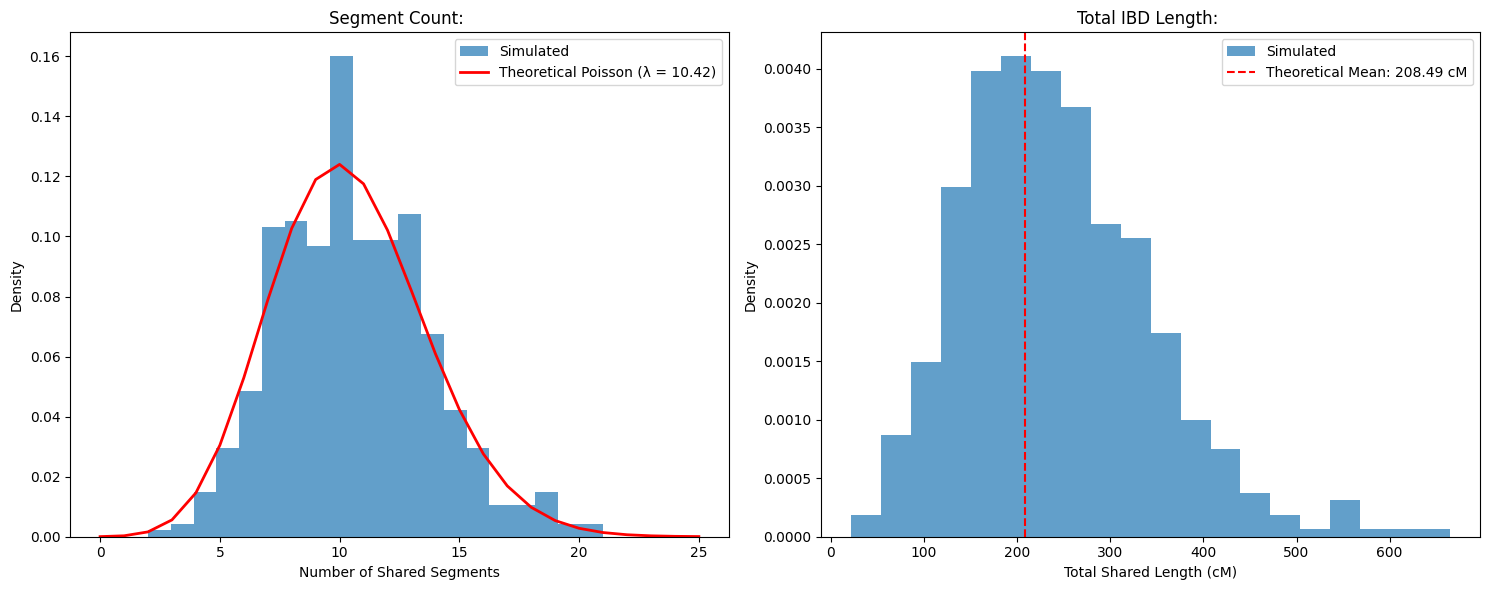

In [31]:
# Interactive calculator for custom relationship exploration
# Try different meiotic distances and see the results

# Define a function to run the interactive exploration
def explore_custom_relationship(up_meioses, down_meioses, num_ancestors, min_seg_len=3.0):
    """
    Explore a custom relationship by visualizing its expected distributions
    
    Args:
        up_meioses: Number of meioses up to the common ancestor
        down_meioses: Number of meioses down from the common ancestor
        num_ancestors: Number of shared ancestors
        min_seg_len: Minimum segment length threshold in cM
    """
    # Create calculator with the specified threshold
    custom_calc = BonsaiDistributionCalculator(min_seg_len=min_seg_len, genome_length=genome_length)
    
    # Get relationship details
    relation_tuple = (up_meioses, down_meioses, num_ancestors)
    relationship_details = custom_calc.describe_relationship(relation_tuple)
    
    # Display relationship parameters
    print(f"Analyzing relationship: {up_meioses} meioses up, {down_meioses} meioses down, {num_ancestors} shared ancestor(s)")
    print(f"Total meiotic distance: {up_meioses + down_meioses}")
    print(f"Minimum segment length: {min_seg_len} cM")
    print("\nExpected Distribution Parameters:")
    for key, value in relationship_details.items():
        print(f"  {key}: {value}")
    
    # Run simulation and plot results
    custom_calc.compare_theoretical_vs_simulated(relation_tuple, num_simulations=500)

# Try with example values
explore_custom_relationship(up_meioses=2, down_meioses=3, num_ancestors=1, min_seg_len=3.0)

## Enhanced BonsaiDistributionCalculator Implementation

We've now added the following capabilities to our BonsaiDistributionCalculator:

1. **IBD Simulation**: The `simulate_ibd_segments` method generates realistic IBD segments based on the mathematical models we've explored.

2. **Theoretical vs Simulated Comparison**: The `compare_theoretical_vs_simulated` method allows us to compare our analytical formulas with simulated data.

3. **Visualization**: The calculator now provides rich visualizations to understand IBD distributions.

4. **Interactive Exploration**: The `explore_custom_relationship` function allows custom relationship investigation.

These enhancements make the calculator a powerful tool for understanding the statistical distribution of IBD segments between relatives with different meiotic distances.

## Key Takeaways

- The corrected formula (from ERSA paper) for expected total IBD length: `T_mean = (100/d) * k_mean`
- This formula consistently produces more accurate results compared to the original formula
- The number of shared segments follows a Poisson distribution with mean λ dependent on meiotic distance
- The length of individual segments follows an Exponential distribution with mean 100/d
- Minimum segment length threshold has a significant impact on both expected segment count and total length
- As meiotic distance increases, both the number and total length of expected IBD segments decrease exponentially
- Higher number of shared ancestors increases the expected segment count proportionally